- filtrar delitos patrimoniales
- hacer tasa de delito por mes por municipio con tendencia
- delitos individuales sacar tasa con poblacion mensual

### Dataset:
https://www.gob.mx/sesnsp/acciones-y-programas/datos-abiertos-de-incidencia-delictiva

In [11]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns; sns.set()
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
sns.set(color_codes=True)
import os, datetime
from itertools import product
import math
import statsmodels.api as sm
from scipy.interpolate import interp1d
import urllib.request, json 
from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from calendar import monthrange

In [12]:
path = "/home/nacho/Documents/CESP/incidencia_delictiva_web_gui"
os.chdir(os.path.join(path)) 
delitos_df = pd.read_csv("data/IDM_NM_abr22.csv", encoding='latin-1',thousands=',')
delitos_df = delitos_df[delitos_df['Entidad'] == 'Jalisco']

# Preprocesaminto poblacion ZMG

In [3]:
year_df = pd.DataFrame(index = pd.date_range('1995', '2023', freq='Y', name='year'), columns = ['population'])
year_df.index =year_df.index.year
df_pobl_zmg = year_df.copy()

In [4]:
zmg_poblacion_dict = {
    "Guadalajara" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140039/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Zapopan" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140120/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "San Pedro Tlaquepaque" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140098/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Tonalá" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140101/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Tlajomulco de Zúñiga" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140097/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "El Salto" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140070/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Ixtlahuacán de los Membrillos" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140044/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Juanacatlán" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140051/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Zapotlanejo" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140124/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json",
    "Acatlán de Juárez" : "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000140002/false/BISE/2.0/648e2ab0-9e88-7069-e494-dc7d2f2ab341?type=json"
}

/tmp/ipykernel_21171/521802282.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pobl_df = pobl_df.drop('year', 1)
/tmp/ipykernel_21171/521802282.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing["population_y"] = f(df_missing.index)
/tmp/ipykernel_21171/521802282.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pobl_df = pobl_df.drop('year', 1)
/tmp/ipykernel_21171/521802282.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

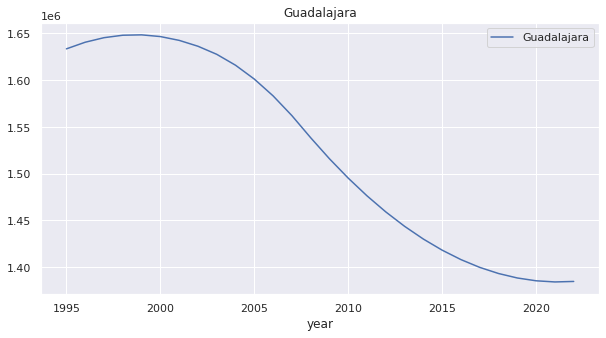

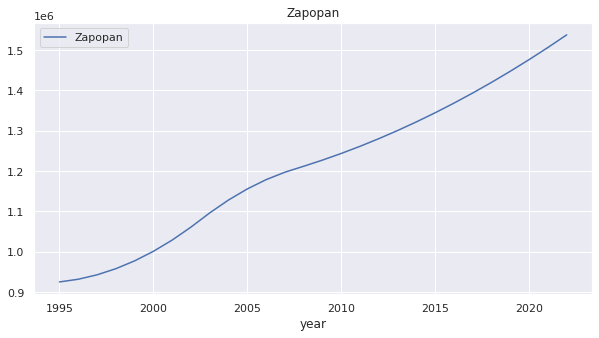

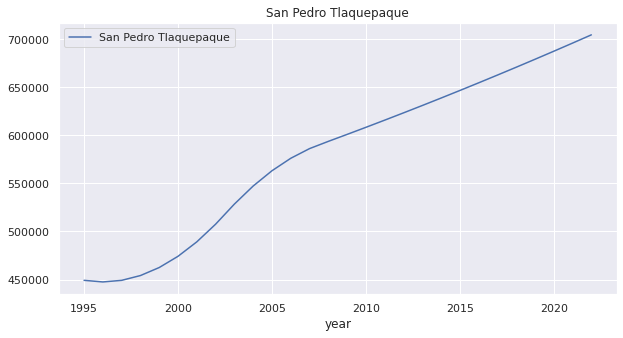

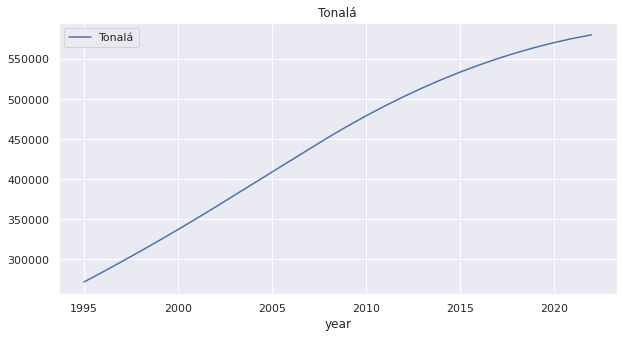

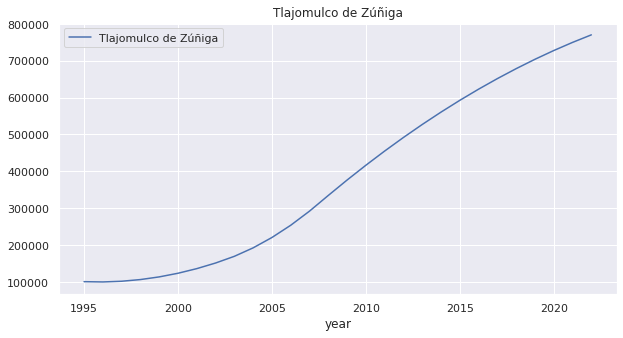

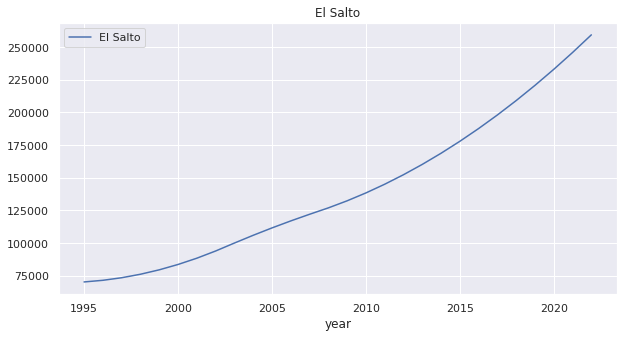

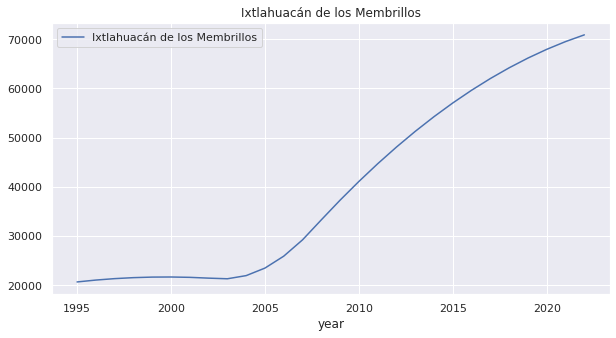

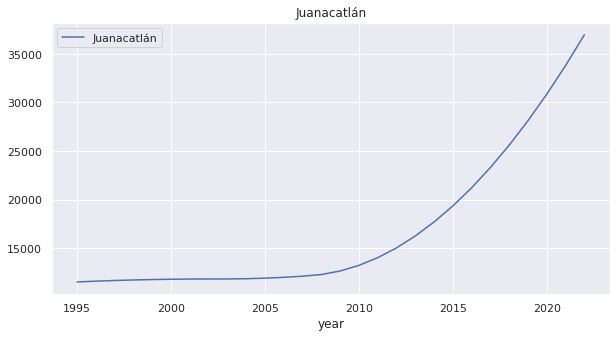

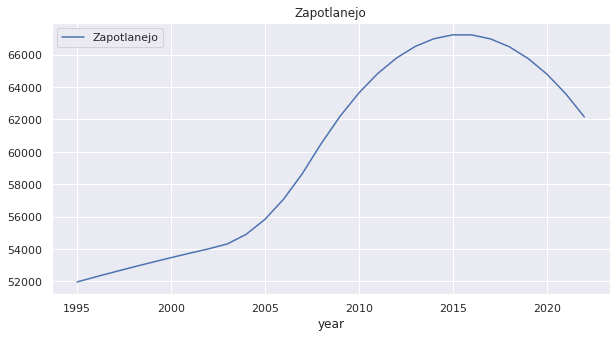

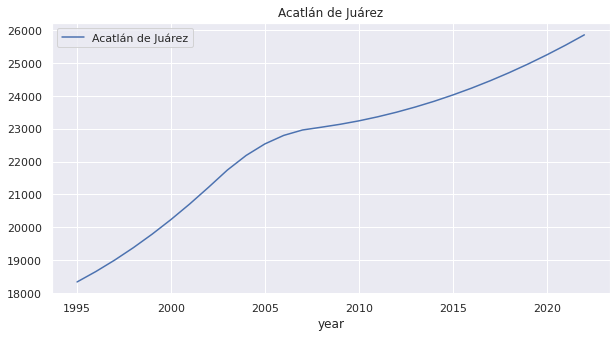

In [5]:
for municipio, link in zmg_poblacion_dict.items():
    with urllib.request.urlopen(link) as url:
        data = json.loads(url.read().decode())
        pobl_df = pd.DataFrame([
            ['1995', int(float(data['Series'][0]['OBSERVATIONS'][0]['OBS_VALUE']))],
            ['2000', int(float(data['Series'][0]['OBSERVATIONS'][1]['OBS_VALUE']))],
            ['2005', int(float(data['Series'][0]['OBSERVATIONS'][2]['OBS_VALUE']))],
            ['2010', int(float(data['Series'][0]['OBSERVATIONS'][3]['OBS_VALUE']))],
            ['2020', int(float(data['Series'][0]['OBSERVATIONS'][4]['OBS_VALUE']))],
        ], columns=['year', 'population'])
        pobl_df.index = pobl_df.year
        pobl_df = pobl_df.drop('year', 1)
        pobl_df.index= pd.to_datetime(pobl_df.index) 
        pobl_df.index = pobl_df.index.year
        #merge datetime nan d list_pobl_zmg.append(pobl_df)f 
        pobl_df = pd.merge(year_df, pobl_df,how='outer',left_index=True,right_index=True)
        pobl_df = pobl_df.drop( pobl_df.columns[0], axis = 1)
        # Split data in training (not NaN values) and missing (NaN values)
        missing = pobl_df.isna().any(axis=1)
        df_training = pobl_df[~missing]
        df_missing = pobl_df[missing]
        #apply interpol and extrapol
        f = interp1d(df_training.index, df_training.iloc[:,0], fill_value="extrapolate", kind = "quadratic")
        df_missing["population_y"] = f(df_missing.index)
        #concat og df and new rows
        pobl_df = pd.concat([df_missing,pobl_df])
        #delete nan
        pobl_df.dropna(subset = ["population_y"], inplace=True)
        #sort and round values
        pobl_df = pobl_df.round().sort_index()
        pobl_df.rename(columns={'population_y': str(municipio)}, inplace=True)
        #plot
        pobl_df.plot(title = str(municipio))
        df_pobl_zmg[str(municipio)] = pobl_df.iloc[:,0]
df_pobl_zmg['population'] = df_pobl_zmg.iloc[:,1:-1].sum(axis=1)

In [6]:
df_pobl_zmg

,population,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
year,,,,,,,,,,,
1995,3534378.0,1633216.0,925113.0,449238.0,271857.0,100797.0,70085.0,20598.0,11513.0,51961.0,18335.0
1996,3560212.0,1640285.0,931806.0,447555.0,284336.0,100038.0,71341.0,20981.0,11593.0,52277.0,18652.0
1997,3594948.0,1645130.0,942743.0,449207.0,297104.0,101941.0,73305.0,21273.0,11661.0,52584.0,19000.0
1998,3638592.0,1647751.0,957924.0,454195.0,310163.0,106505.0,75979.0,21474.0,11717.0,52884.0,19380.0
1999,3691142.0,1648147.0,977350.0,462519.0,323511.0,113731.0,79362.0,21585.0,11760.0,53177.0,19792.0
2000,3752597.0,1646319.0,1001021.0,474178.0,337149.0,123619.0,83453.0,21605.0,11792.0,53461.0,20236.0
2001,3822959.0,1642267.0,1028936.0,489173.0,351077.0,136168.0,88253.0,21535.0,11812.0,53738.0,20712.0
2002,3902223.0,1635990.0,1061095.0,507503.0,365295.0,151379.0,93763.0,21373.0,11819.0,54006.0,21219.0
2003,3988724.0,1627374.0,1096409.0,528388.0,379764.0,169558.0,99856.0,21245.0,11820.0,54310.0,21743.0


# Preprocesamiento delitos ZMG

In [7]:
delitos_df.tail(3)

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
1654923,2022,14,Jalisco,14998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,5,...,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654924,2022,14,Jalisco,14998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Electorales,Electorales,Electorales,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654925,2022,14,Jalisco,14998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,8,...,12,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
delitos_df['Modalidad'].value_counts()

Con violencia                                                                          12096
Sin violencia                                                                          12096
Con arma de fuego                                                                       5040
Con otro elemento                                                                       5040
No especificado                                                                         5040
Con arma blanca                                                                         5040
En accidente de tránsito                                                                2016
Despojo                                                                                 1008
Violencia familiar                                                                      1008
Otros delitos contra el patrimonio                                                      1008
Abuso de confianza                                                    

In [42]:
delitos_df['Bien jurídico afectado'].value_counts()

El patrimonio                                         42336
La vida y la Integridad corporal                      24192
Otros bienes jurídicos afectados (del fuero común)    10080
Libertad personal                                      8064
La libertad y la seguridad sexual                      7056
La familia                                             4032
La sociedad                                            3024
Name: Bien jurídico afectado, dtype: int64

In [8]:
dict_delitos_sum = {}
municipios_zmg_list = list(zmg_poblacion_dict.keys())
# municipios_jalisco_list = delitos_df.Municipio.value_counts().index.tolist()
delitos_list = delitos_df['Tipo de delito'].value_counts().index.tolist()
zmg_delitos_df = delitos_df[delitos_df['Municipio'].isin(municipios_zmg_list)]

In [9]:
zmg_delitos_df['delito_subtipo'] = zmg_delitos_df[zmg_delitos_df.columns[6:8]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
zmg_delito_subtipo_list = zmg_delitos_df['delito_subtipo'].value_counts().index.tolist()

zmg_delitos_df['delito_subtipo_modalidad'] = zmg_delitos_df[zmg_delitos_df.columns[6:9]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
zmg_delito_subtipo_modalidad_list = zmg_delitos_df['delito_subtipo_modalidad'].value_counts().index.tolist()

/tmp/ipykernel_21171/745404791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zmg_delitos_df['delito_subtipo'] = zmg_delitos_df[zmg_delitos_df.columns[6:8]].apply(
/tmp/ipykernel_21171/745404791.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zmg_delitos_df['delito_subtipo_modalidad'] = zmg_delitos_df[zmg_delitos_df.columns[6:9]].apply(


In [10]:
delitos_df[delitos_df['Municipio'] == 'Tequila'].tail(3)

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
1651787,2022,14,Jalisco,14094,Tequila,Otros bienes jurídicos afectados (del fuero co...,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,0,...,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651788,2022,14,Jalisco,14094,Tequila,Otros bienes jurídicos afectados (del fuero co...,Electorales,Electorales,Electorales,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651789,2022,14,Jalisco,14094,Tequila,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,0,...,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
zmg_delitos_df[zmg_delitos_df['Municipio'] == 'Guadalajara'].tail(3)

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,delito_subtipo,delito_subtipo_modalidad
1646397,2022,14,Jalisco,14039,Guadalajara,Otros bienes jurídicos afectados (del fuero co...,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Delitos cometidos por servidores públicos_Deli...,Delitos cometidos por servidores públicos_Deli...
1646398,2022,14,Jalisco,14039,Guadalajara,Otros bienes jurídicos afectados (del fuero co...,Electorales,Electorales,Electorales,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electorales_Electorales,Electorales_Electorales_Electorales
1646399,2022,14,Jalisco,14039,Guadalajara,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Otros delitos del Fuero Común_Otros delitos de...,Otros delitos del Fuero Común_Otros delitos de...


# Tabla de tasa de criminalidad en ZMG

In [12]:
updated_year = zmg_delitos_df['Año'].max()
df_lastyear = zmg_delitos_df[zmg_delitos_df['Año'] == updated_year][['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']]
notnull_months_list = df_lastyear.columns[df_lastyear.notnull().any()].tolist()
updated_month_1 = str(df_lastyear.columns[df_lastyear.notnull().any()].tolist().__len__() + 1).zfill(2)
updated_month = str(df_lastyear.columns[df_lastyear.notnull().any()].tolist().__len__()).zfill(2)

for municipio in municipios_zmg_list:
    delitos_municipio = zmg_delitos_df[zmg_delitos_df['Municipio'] == municipio]
    delitos_sum_df = pd.DataFrame(index = pd.date_range('2015-01', str(updated_year)+'-'+ updated_month_1, freq='M'))
    delitos_sum_df.index.name = 'date'
    years = np.arange(2015,updated_year + 1)
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    for delito in delitos_list:
        values_delito = []
        for year in years:
            if year != updated_year:
                for mes in meses:
                    value = delitos_municipio.loc[(delitos_municipio['Tipo de delito'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                    values_delito.append(value)
            else:
                for mes in meses:
                    if any(mes in x  for x in notnull_months_list):
                        value = delitos_municipio.loc[(delitos_municipio['Tipo de delito'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                        values_delito.append(value)
                    else:
                        # value = int(0)
                        # values_delito.append(np.nan)
                        pass
        delitos_sum_df[str(delito)] = values_delito
        dict_delitos_sum[municipio] = delitos_sum_df

In [14]:
dict_delitos_sum['Guadalajara'].tail(3)

,Robo,Homicidio,Lesiones,Secuestro,Feminicidio,Narcomenudeo,Violencia de género en todas sus modalidades distinta a la violencia familiar,Incumplimiento de obligaciones de asistencia familiar,Otros delitos contra la familia,Corrupción de menores,...,Abuso sexual,Hostigamiento sexual,Extorsión,Violación simple,Violación equiparada,Incesto,Otros delitos que atentan contra la libertad y la seguridad sexual,Fraude,Abuso de confianza,Otros delitos del Fuero Común
date,,,,,,,,,,,,,,,,,,,,,
2022-02-28,1487.0,28.0,137.0,2.0,0.0,18.0,0.0,0.0,8.0,4.0,...,31.0,1.0,10.0,11.0,0.0,0.0,55.0,232.0,35.0,357.0
2022-03-31,1630.0,31.0,176.0,1.0,0.0,29.0,0.0,0.0,11.0,3.0,...,35.0,2.0,17.0,10.0,0.0,0.0,57.0,287.0,39.0,408.0
2022-04-30,1370.0,37.0,173.0,1.0,0.0,33.0,0.0,0.0,8.0,3.0,...,45.0,1.0,15.0,12.0,0.0,0.0,46.0,231.0,27.0,481.0


### Suma de delitos

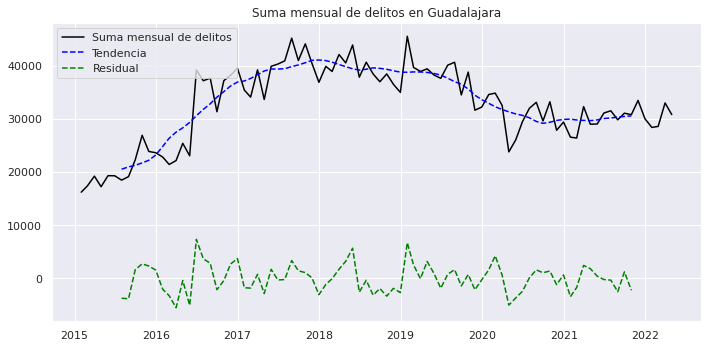

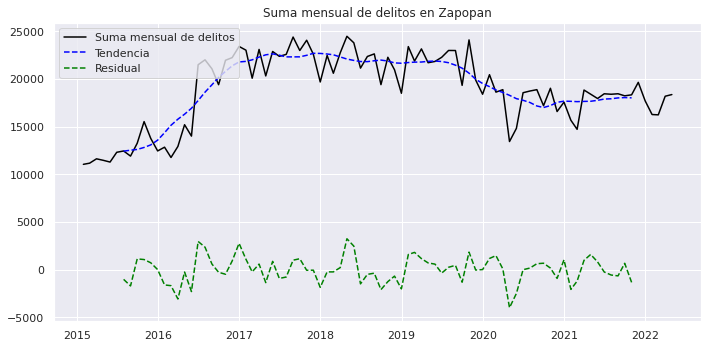

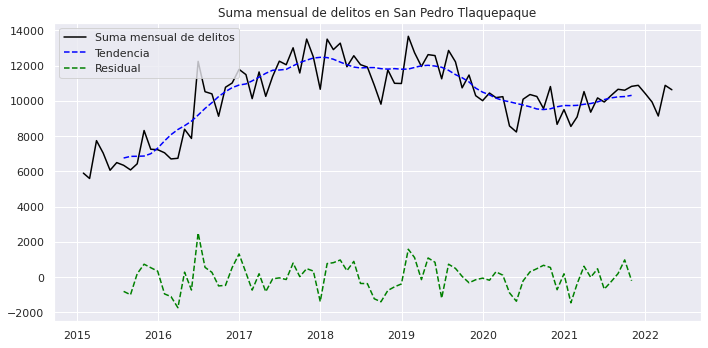

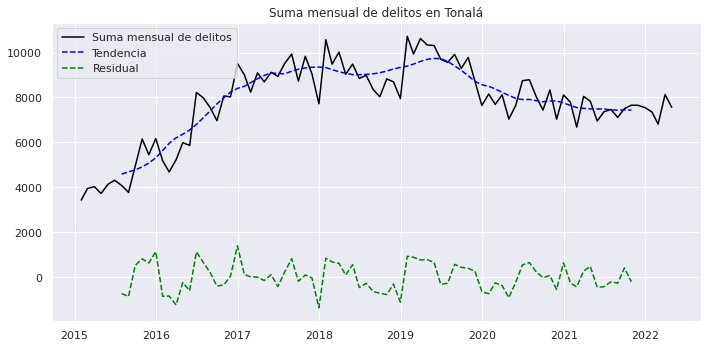

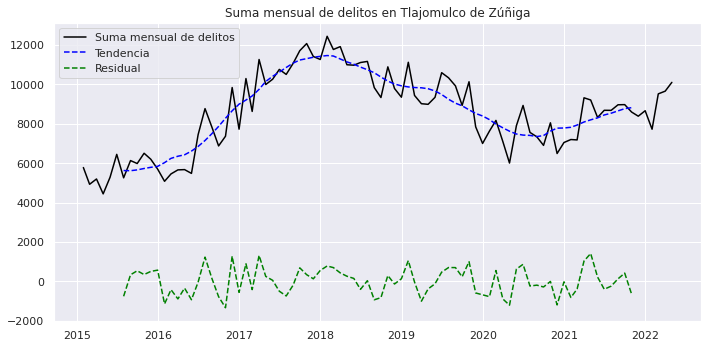

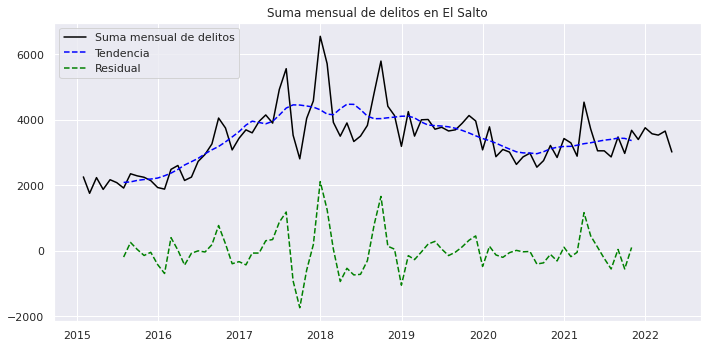

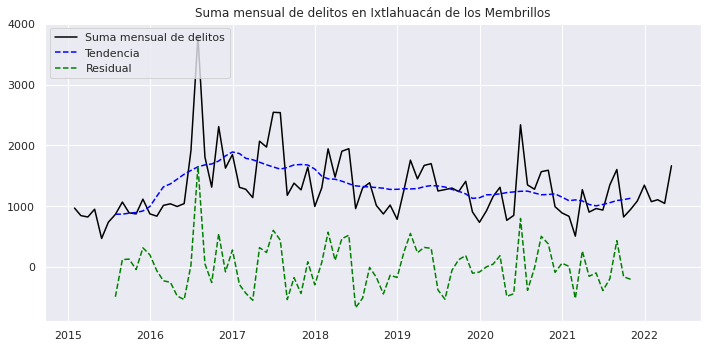

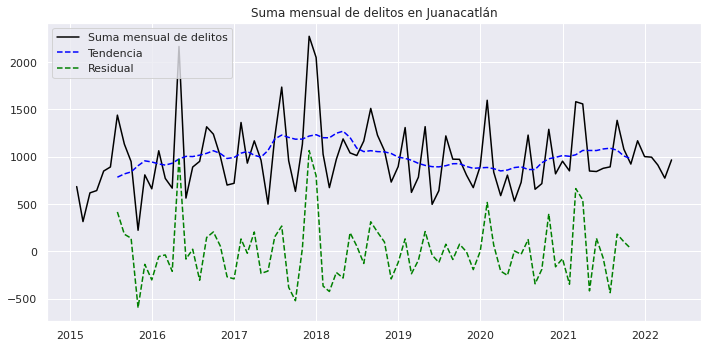

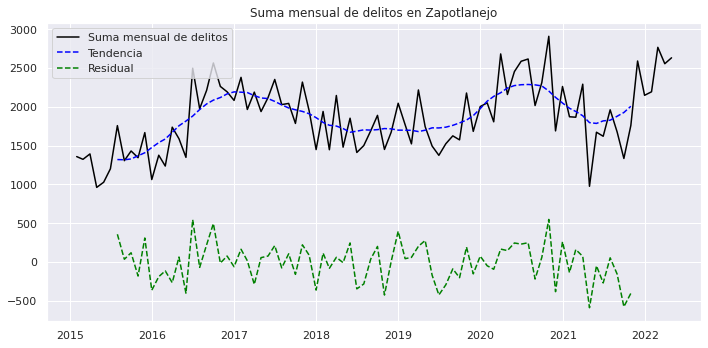

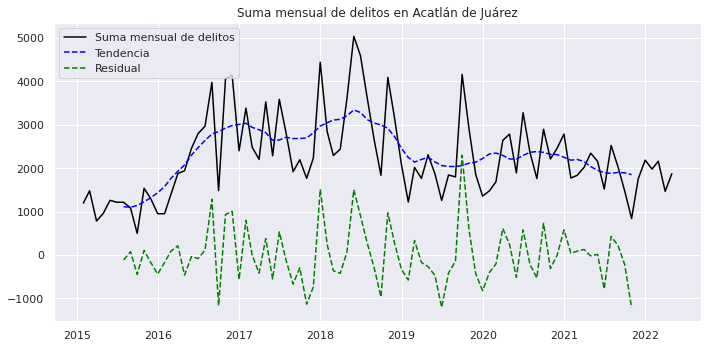

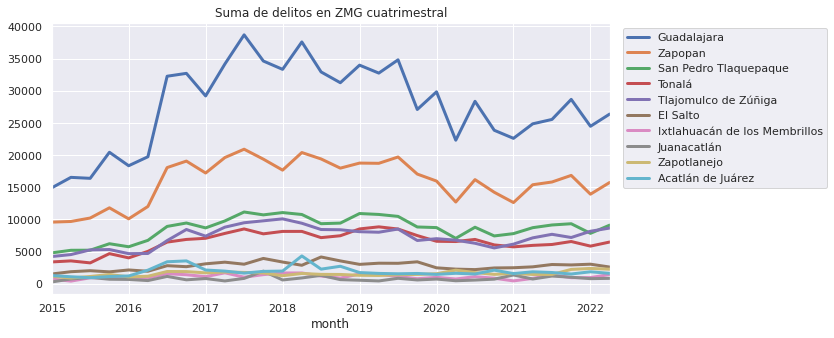

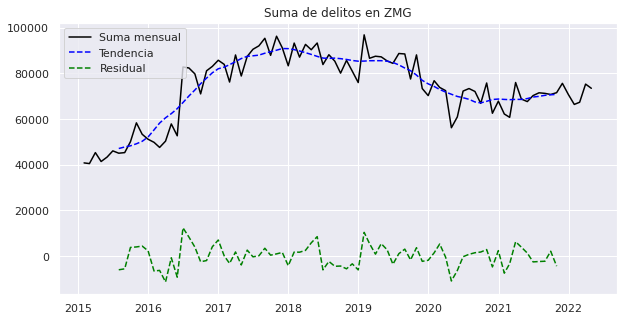

,ZMG,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
month,,,,,,,,,,,
2015-01-31,40805.504470,13875.201535,9470.485205,5053.242799,2940.253174,4950.073262,1936.639003,829.014356,587.322546,1163.272592,1024.913812
2015-02-28,40510.092049,14904.096572,9574.721646,4792.068661,3382.512415,4222.759295,1507.105865,723.388365,270.417098,1133.022131,1266.921700
2015-03-31,45315.156208,16463.842677,9966.666934,6632.962094,3454.421359,4452.801386,1917.788802,703.445811,530.450344,1192.776801,670.463712
2015-04-30,41418.099628,14758.635253,9834.119215,6029.495853,3193.250309,3805.647577,1609.638002,813.096812,551.337395,822.879212,817.721824
2015-05-31,43350.064935,16535.617366,9675.295045,5193.516445,3545.799359,4528.250950,1862.933672,400.741190,728.145730,879.765179,1078.222990
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,70773.420531,25702.676879,15174.990402,8927.675948,6471.764210,7420.284928,3223.275428,1153.003783,859.179081,1840.569872,1871.853649
2022-01-31,66407.642215,24308.204890,13948.135723,8509.898648,6305.717170,6616.481769,3065.771968,920.092842,853.900887,1879.438316,1694.918794
2022-02-28,67355.297593,24478.715965,13918.691927,7830.520912,5841.939228,8153.350214,3031.281578,947.033124,782.814035,2370.950611,1850.568680


In [42]:
df_delito_zmg = pd.DataFrame(index = pd.date_range('2015', str(updated_year + 1), freq='M', name='month'), columns = ['delito'])
#eliminar hasta el ultimo mes null
n_null_months = len(df_lastyear.columns[df_lastyear.isnull().any()].tolist())
df_delito_zmg.drop(df_delito_zmg.tail(n_null_months).index,inplace=True) # drop last n rows

for municipio in municipios_zmg_list:
    dict_delitos_sum[str(municipio)]['total_sum'] = dict_delitos_sum[str(municipio)].sum(axis=1)
    df_suma_delito = dict_delitos_sum[str(municipio)]['total_sum'].resample('M').sum()
    #df_suma_delito.index = df_suma_delito.index.year
    df_delito_zmg[str(municipio)] = df_suma_delito
    #plot
    df = pd.DataFrame(dict_delitos_sum[str(municipio)].sum(axis=1), columns=[str(municipio)])
    decom = sm.tsa.seasonal_decompose(df, model = 'additive')
    fig, ax = plt.subplots()
    ax.plot(df, label='Suma mensual de delitos', color='black')
    ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='blue')  
    ax.plot(decom.resid.index, decom.resid.values, label = 'Residual', linestyle='--', color='green') 
    ax.set_title("Suma mensual de delitos en "+str(municipio))
    ax.legend(loc='upper left')
    fig.tight_layout()
    plt.show()

df_delito_zmg.resample('1Q', closed='left').last().plot(title = "Suma de delitos en ZMG cuatrimestral", lw=3)
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

df_delito_zmg['delito'] = df_delito_zmg.iloc[:,1:-1].sum(axis=1)
decom = sm.tsa.seasonal_decompose(df_delito_zmg['delito'], model = 'additive')
fig, ax = plt.subplots()
ax.plot(df_delito_zmg['delito'], label='Suma mensual', color='black')
ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='blue')
ax.plot(decom.trend.index, decom.resid.values, label = 'Residual', linestyle='--', color='green')
ax.legend(loc='upper left')
ax.set_title('Suma de delitos en ZMG')
plt.show()

first_column = df_delito_zmg.pop('delito')
df_delito_zmg.insert(0, 'ZMG', first_column)
display(df_delito_zmg)

### Tasa de Criminalidad

In [16]:
df_pobl_zmg.iloc[-8:,]

,population,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
year,,,,,,,,,,,
2015,4856572.0,1418301.0,1344710.0,646357.0,533136.0,592697.0,177752.0,57051.0,19343.0,67225.0,24029.0
2016,4931636.0,1408230.0,1368600.0,654309.0,541905.0,622989.0,187526.0,59641.0,21214.0,67222.0,24238.0
2017,5007848.0,1399927.0,1393723.0,662362.0,549967.0,651640.0,197923.0,62027.0,23301.0,66978.0,24465.0
2018,5085212.0,1393392.0,1420079.0,670516.0,557322.0,678651.0,208943.0,64211.0,25604.0,66494.0,24709.0
2019,5163726.0,1388626.0,1447668.0,678771.0,563971.0,704021.0,220586.0,66191.0,28122.0,65770.0,24971.0
2020,5243392.0,1385629.0,1476491.0,687127.0,569913.0,727750.0,232852.0,67969.0,30855.0,64806.0,25250.0
2021,5324207.0,1384400.0,1506547.0,695584.0,575148.0,749838.0,245741.0,69544.0,33804.0,63601.0,25546.0
2022,5406174.0,1384940.0,1537835.0,704143.0,579677.0,770286.0,259253.0,70916.0,36968.0,62156.0,25860.0


In [17]:
df_pobl_zmg.rename(columns={'population':'ZMG'}, inplace=True)
df_pobl_month_zmg = df_pobl_zmg.iloc[-8:,]
df_pobl_month_zmg.index = pd.to_datetime(df_pobl_month_zmg.index, format='%Y')
df_pobl_month_zmg.index = df_pobl_month_zmg.index.to_period('M').to_timestamp('M')

n_days_month = monthrange(int(updated_year), int(updated_month))[1]
df_reindexed = df_pobl_month_zmg.reindex(pd.date_range(start='2015-01-31', end=str(updated_year)+'-'+str(updated_month)+'-'+str(n_days_month), freq='M'))
df_reindexed.index.names = ['year']
df_reindexed = df_reindexed.interpolate(method='quadratic', limit_direction='both')

In [17]:
df_pobl_zmg.rename(columns={'population':'ZMG'}, inplace=True)
df_pobl_month_zmg = df_pobl_zmg.iloc[-8:,]
df_pobl_month_zmg.index = pd.to_datetime(df_pobl_month_zmg.index, format='%Y')
df_pobl_month_zmg.index = df_pobl_month_zmg.index.to_period('M').to_timestamp('M')

n_days_month = monthrange(int(updated_year), int(updated_month))[1]
df_reindexed = df_pobl_month_zmg.reindex(pd.date_range(start='2015-01-31', end=str(updated_year)+'-'+str(updated_month)+'-'+str(n_days_month), freq='M'))
df_reindexed.index.names = ['year']
df_reindexed = df_reindexed.interpolate(method="quadratic", fill_value="extrapolate")

In [18]:
df_delito_zmg

,ZMG,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
month,,,,,,,,,,,
2015-01-31,4630.0,1696.0,1200.0,598.0,328.0,569.0,149.0,31.0,9.0,50.0,19.0
2015-02-28,4632.0,1803.0,1200.0,561.0,377.0,495.0,117.0,27.0,4.0,48.0,23.0
2015-03-31,5203.0,2038.0,1245.0,771.0,390.0,523.0,149.0,27.0,9.0,51.0,12.0
2015-04-30,4805.0,1832.0,1255.0,704.0,362.0,452.0,125.0,31.0,9.0,35.0,16.0
2015-05-31,5053.0,2071.0,1237.0,608.0,399.0,531.0,143.0,15.0,11.0,38.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,8245.0,3260.0,1858.0,1049.0,744.0,893.0,293.0,51.0,23.0,74.0,37.0
2022-01-31,7689.0,3061.0,1708.0,997.0,710.0,796.0,277.0,41.0,23.0,76.0,33.0
2022-02-28,7715.0,3051.0,1694.0,913.0,652.0,970.0,277.0,42.0,21.0,95.0,36.0


In [19]:
df_reindexed

,ZMG,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
year,,,,,,,,,,,
2015-01-31,4.856572e+06,1.418301e+06,1.344710e+06,646357.000000,533136.000000,592697.000000,177752.000000,57051.000000,19343.000000,67225.000000,24029.000000
2015-02-28,4.862300e+06,1.417465e+06,1.346502e+06,646964.513897,533834.763786,595082.617911,178481.133849,57257.231142,19479.167816,67233.266843,24044.419135
2015-03-31,4.868647e+06,1.416551e+06,1.348495e+06,647637.603641,534603.341263,597711.849603,179292.392291,57484.095780,19631.351830,67240.772432,24061.609284
2015-04-30,4.874796e+06,1.415680e+06,1.350430e+06,648289.466151,535342.069296,600244.272675,180081.486403,57702.178706,19780.054251,67246.388017,24078.363939
2015-05-31,4.881156e+06,1.414792e+06,1.352439e+06,648963.558928,536100.196423,602848.715333,180901.022460,57926.018782,19935.188573,67250.487969,24095.800079
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,5.399156e+06,1.384826e+06,1.535125e+06,703410.873895,579318.973620,768609.738547,258079.350559,70807.120657,36690.511268,62288.207469,25832.583415
2022-01-31,5.406174e+06,1.384940e+06,1.537835e+06,704143.000000,579677.000000,770286.000000,259253.000000,70916.000000,36968.000000,62156.000000,25860.000000
2022-02-28,5.412522e+06,1.385054e+06,1.540291e+06,704805.104437,579996.130052,771790.402798,260317.227574,71013.122590,37220.033526,62035.074021,25884.882727


<AxesSubplot:xlabel='year'>

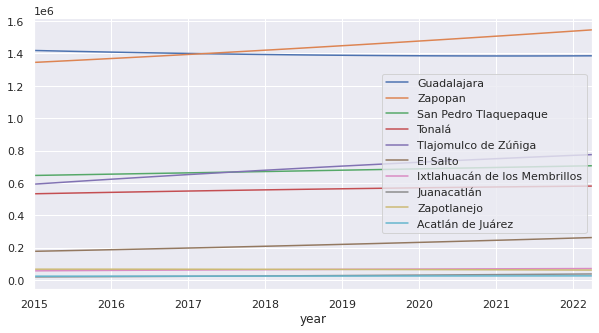

In [20]:
df_reindexed.iloc[:,1:].plot()

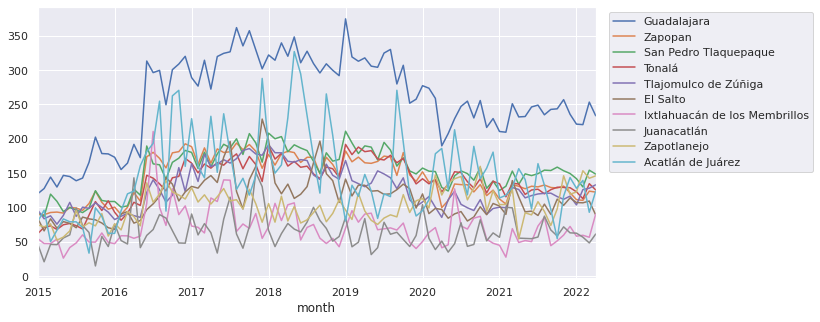

In [22]:
#tasa de criminalidad

((df_delito_zmg.loc[:, df_delito_zmg.columns != 'ZMG']/df_reindexed.loc[:, df_delito_zmg.columns != 'ZMG'])*100000).plot()
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

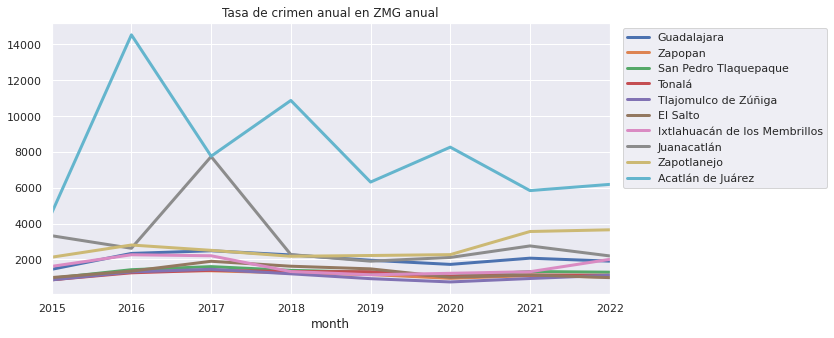

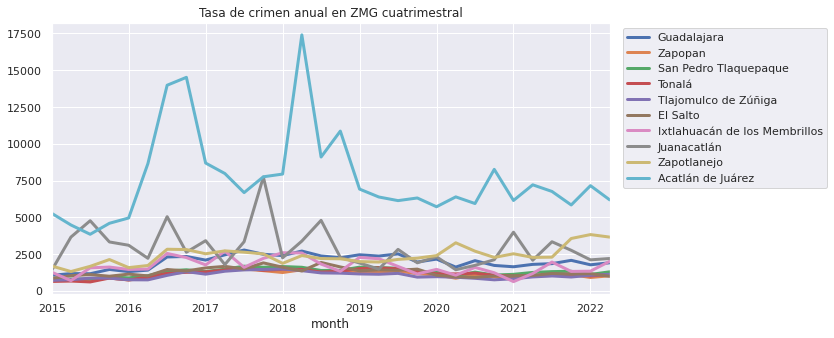

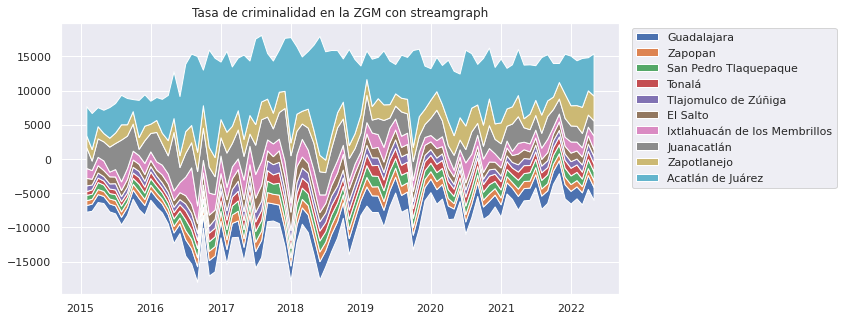

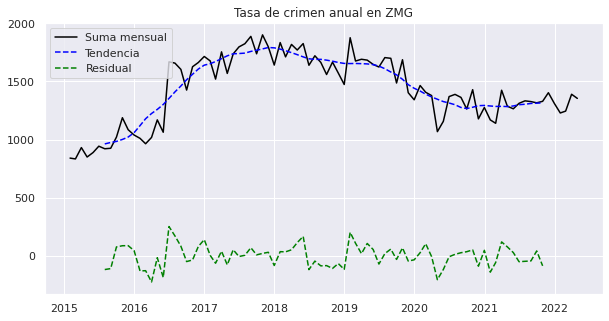

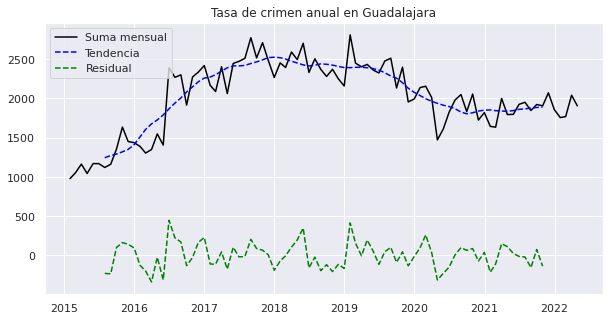

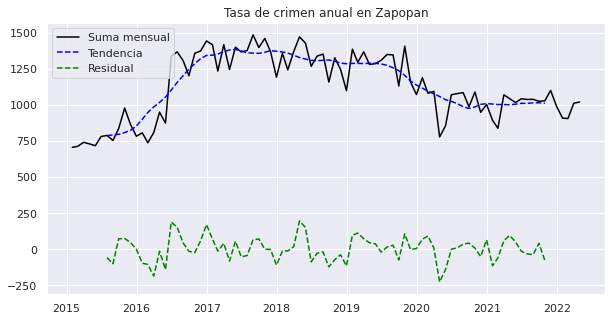

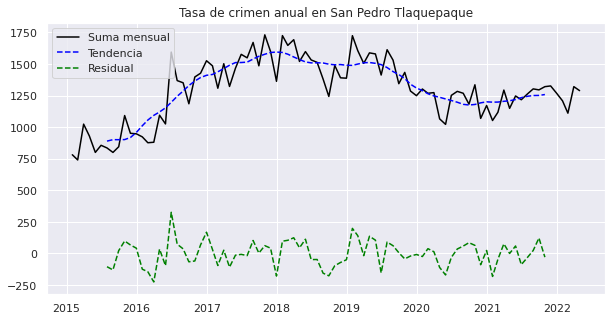

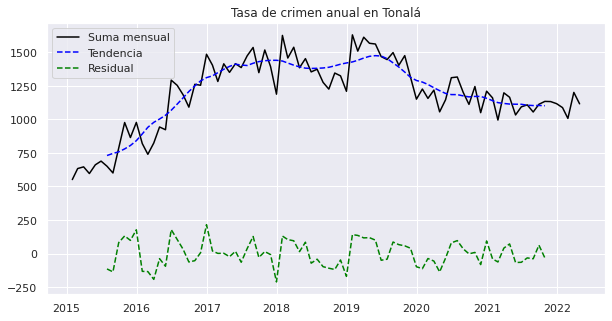

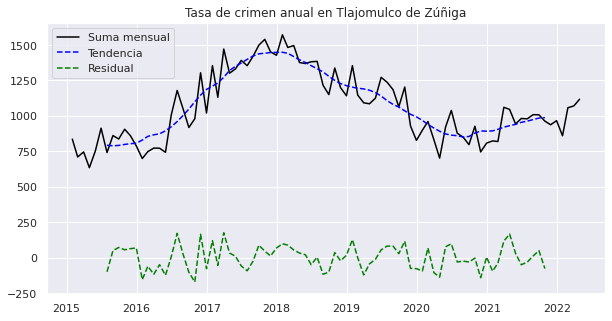

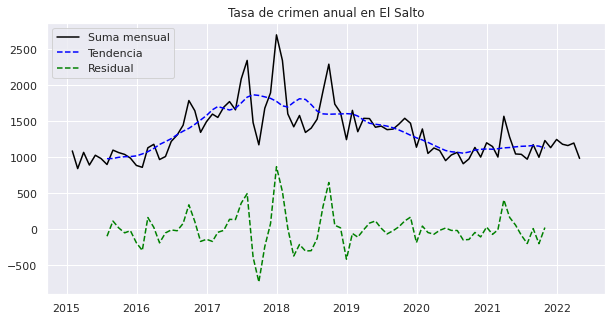

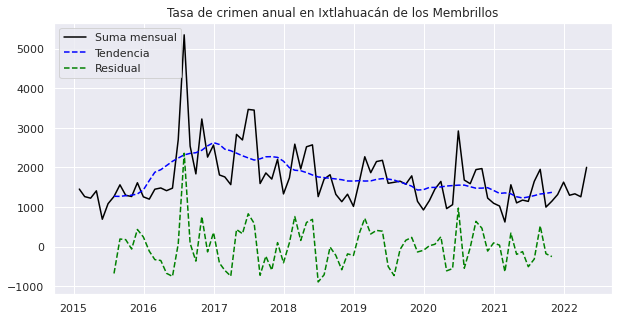

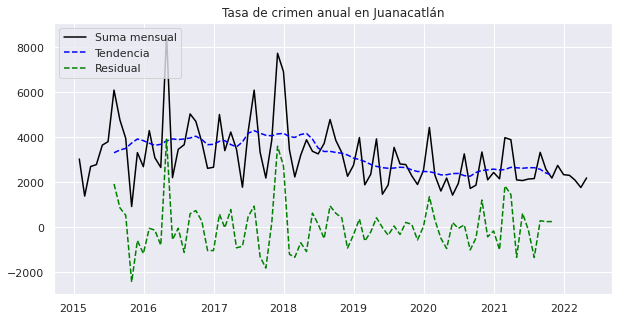

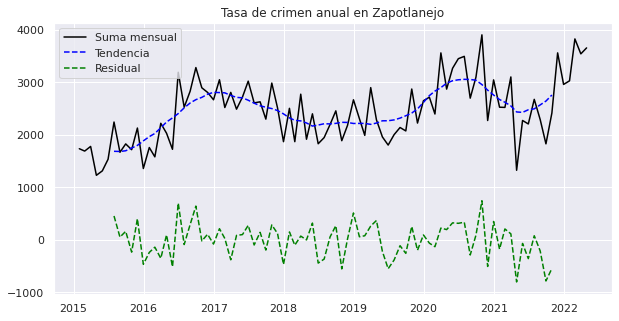

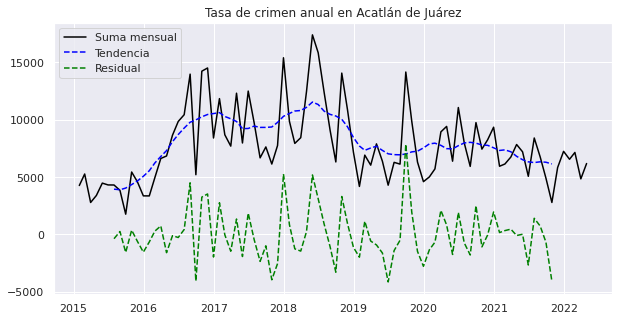

,ZMG,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
month,,,,,,,,,,,
2015-01-31,840.212077,978.297381,704.277146,781.803678,551.501526,835.177715,1089.517419,1453.110998,3036.357057,1730.416649,4265.320290
2015-02-28,833.146721,1051.461495,711.080926,740.700388,633.625355,709.608913,844.406259,1263.400885,1388.237425,1685.210587,5269.088400
2015-03-31,930.754536,1162.248217,739.095787,1024.178037,646.165314,744.974587,1069.643155,1223.722495,2702.057141,1773.889201,2786.445843
2015-04-30,849.637597,1042.512329,728.221107,930.062290,596.487833,634.016475,893.838692,1409.126709,2787.340155,1223.677935,3396.085489
2015-05-31,888.110678,1168.766895,715.396158,800.278594,661.406092,751.142175,1029.808260,691.815523,3652.565050,1308.191518,4474.734131
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,1310.823797,1856.022577,988.517917,1269.197887,1117.133135,965.416460,1248.947435,1628.372644,2341.692856,2954.925093,7246.095439
2022-01-31,1228.366720,1755.181083,906.998197,1208.546936,1087.798407,858.964303,1182.540595,1297.440412,2309.837933,3023.743993,6554.210338
2022-02-28,1244.434636,1767.347150,903.640625,1111.019325,1007.237622,1056.420264,1164.456769,1333.602986,2103.206152,3821.951772,7149.225668


In [43]:
df_crime_rate_zmg = ((df_delito_zmg.loc[:, df_delito_zmg.columns != 'ZMG']/df_reindexed.loc[:, df_delito_zmg.columns != 'ZMG'])*100000)

df_crime_rate_zmg.resample('Y', closed='left').last().plot(title = "Tasa de crimen anual en ZMG anual", lw=3)
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

df_crime_rate_zmg.resample('1Q', closed='left').last().plot(title = "Tasa de crimen anual en ZMG cuatrimestral", lw=3)
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

# df_crime_rate_zmg = ((df_delito_zmg/df_reindexed)*100000)
df_crime_rate_zmg = ((df_delito_zmg.loc[:, df_delito_zmg.columns != 'ZMG']/df_reindexed.loc[:, df_delito_zmg.columns != 'ZMG'])*100000)

plt.stackplot(
    df_crime_rate_zmg.index,
    *(df_crime_rate_zmg.iloc[:,i] for i in range(len(df_crime_rate_zmg.columns))),
    labels=df_crime_rate_zmg.columns,
    baseline='weighted_wiggle'
)
plt.title('Tasa de criminalidad en la ZGM con streamgraph')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

df_crime_rate_zmg = ((df_delito_zmg/df_reindexed)*100000)
for column in df_crime_rate_zmg:
    decom = sm.tsa.seasonal_decompose(df_crime_rate_zmg[str(column)], model = 'additive')
    fig, ax = plt.subplots()
    ax.plot(df_crime_rate_zmg[str(column)], label='Suma mensual', color='black')
    ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='blue')
    ax.plot(decom.trend.index, decom.resid.values, label = 'Residual', linestyle='--', color='green')
    ax.legend(loc='upper left')
    ax.set_title("Tasa de crimen anual en "+str(column))
    plt.show()

display(df_crime_rate_zmg)



In [24]:
def _color_red_or_green(val):
    color = 'green' if val < 0 else 'red'
    return 'color: %s' % color
#Cambio porcentual de delitos en ZMG
(df_crime_rate_zmg.pct_change().loc['2015-01-31 00:00:00':]*100).style.applymap(_color_red_or_green).to_excel("Cambio porcentual de delitos en ZMG.xlsx")
(df_crime_rate_zmg.pct_change().iloc[-24:,]*100).style.applymap(_color_red_or_green)

,ZMG,Guadalajara,Zapopan,San Pedro Tlaquepaque,Tonalá,Tlajomulco de Zúñiga,El Salto,Ixtlahuacán de los Membrillos,Juanacatlán,Zapotlanejo,Acatlán de Juárez
month,,,,,,,,,,,
2020-05-31 00:00:00,8.885565,9.427437,10.320862,-4.040911,9.068860,30.062982,-13.117095,10.492821,-31.781467,14.647300,-31.981382
2020-06-30 00:00:00,14.926819,10.462484,22.007517,17.818553,13.674707,11.257278,7.564012,180.108821,35.345177,4.754083,68.589966
2020-07-31 00:00:00,1.389081,7.831972,-0.671403,4.960867,-0.883667,-15.506536,3.711950,-42.640764,65.382860,2.358599,-27.848796
2020-08-31 00:00:00,-1.271735,3.108530,-0.120177,-2.560710,-8.780995,-4.785593,-14.675563,-6.180876,-44.430693,-23.533545,-23.152866
2020-09-30 00:00:00,-7.273587,-9.614346,-7.868209,-6.495299,-6.684447,-4.041759,7.337993,23.177298,6.346276,15.675411,59.846450
2020-10-31 00:00:00,11.560444,11.026266,8.720608,13.250510,10.543642,16.542664,17.338436,3.254136,78.619024,24.597010,-25.074704
2020-11-30 00:00:00,-15.817568,-15.352753,-12.088024,-19.185278,-14.593376,-19.078764,-11.456863,-38.443925,-37.503975,-41.080147,11.003536
2020-12-31 00:00:00,8.034078,5.984299,6.824565,8.362209,14.037408,9.285761,18.353612,-10.973996,22.584120,31.893421,14.884448
2021-01-31 00:00:00,-7.386391,-8.225905,-10.325152,-9.989200,-2.595794,1.933419,-3.541107,-6.230255,-10.215230,-16.309254,-37.020146


# Tabla de tendencia de delito por municipios

In [25]:
updated_year = zmg_delitos_df['Año'].max()
df_lastyear = zmg_delitos_df[zmg_delitos_df['Año'] == updated_year][['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']]
notnull_months_list = df_lastyear.columns[df_lastyear.notnull().any()].tolist()
updated_month_1 = str(df_lastyear.columns[df_lastyear.notnull().any()].tolist().__len__() + 1).zfill(2)
updated_month = str(df_lastyear.columns[df_lastyear.notnull().any()].tolist().__len__()).zfill(2)

for municipio in municipios_zmg_list:
    delitos_municipio = zmg_delitos_df[zmg_delitos_df['Municipio'] == municipio]
    delitos_sum_df = pd.DataFrame(index = pd.date_range('2015-01', str(updated_year)+'-'+ updated_month_1, freq='M'))
    delitos_sum_df.index.name = 'date'
    years = np.arange(2015,updated_year + 1)
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    for delito in delitos_list:
        values_delito = []
        for year in years:
            if year != updated_year:
                for mes in meses:
                    value = delitos_municipio.loc[(delitos_municipio['Tipo de delito'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                    values_delito.append(value)
            else:
                for mes in meses:
                    if any(mes in x  for x in notnull_months_list):
                        value = delitos_municipio.loc[(delitos_municipio['Tipo de delito'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                        values_delito.append(value)
                    else:
                        # value = int(0)
                        # values_delito.append(np.nan)
                        pass          
        delitos_sum_df[str(delito)] = values_delito
        dict_delitos_sum[municipio] = delitos_sum_df

    for delito in zmg_delito_subtipo_list:
        values_delito = []
        for year in years:
            if year != updated_year:
                for mes in meses:
                    value = delitos_municipio.loc[(delitos_municipio['delito_subtipo'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                    values_delito.append(value)
            else:
                for mes in meses:
                    if any(mes in x  for x in notnull_months_list):
                        value = delitos_municipio.loc[(delitos_municipio['delito_subtipo'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                        values_delito.append(value)
                    else:
                        # value = int(0)
                        # values_delito.append(value)
                        pass
        delitos_sum_df[str(delito)] = values_delito
        dict_delitos_sum[municipio] = delitos_sum_df

    for delito in zmg_delito_subtipo_modalidad_list:
        values_delito = []
        for year in years:
            if year != updated_year:
                for mes in meses:
                    value = delitos_municipio.loc[(delitos_municipio['delito_subtipo_modalidad'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                    values_delito.append(value)
            else:
                for mes in meses:
                    if any(mes in x  for x in notnull_months_list):
                        value = delitos_municipio.loc[(delitos_municipio['delito_subtipo_modalidad'] == delito) & (delitos_municipio['Año'] == year), mes].sum()
                        values_delito.append(value)
                    else:
                        # value = int(0)
                        # values_delito.append(value)
                        pass
        # checar porque no funciona
        # df_value_delito = pd.DataFrame(values_delito, columns=[str(delito)])
        # delitos_sum_df = pd.concat((delitos_sum_df,df_value_delito),axis=1)
        delitos_sum_df[str(delito)] = values_delito
        dict_delitos_sum[municipio] = delitos_sum_df

/tmp/ipykernel_21171/1793410696.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  delitos_sum_df[str(delito)] = values_delito


In [26]:
#calcular tasa delictiva por delito y municipio
dict_delitos_tasa = dict_delitos_sum.copy()
for municipio in df_reindexed.iloc[:,1:].columns:
    for i in range(0, len(dict_delitos_tasa[str(municipio)])):
        dict_delitos_tasa[str(municipio)].iloc[:,i] = (dict_delitos_tasa[str(municipio)].iloc[:,i] / df_reindexed[str(municipio)]) * 100000

In [27]:
dict_delitos_tasa['Guadalajara'][['Robo','Homicidio']]

,Robo,Homicidio
date,,
2015-01-31,34.477872,1.903686
2015-02-28,37.461248,1.763712
2015-03-31,38.756096,1.129504
2015-04-30,31.857489,1.130199
2015-05-31,39.581798,1.625681
...,...,...
2021-12-31,120.809431,2.960661
2022-01-31,115.600676,1.949543
2022-02-28,107.360419,2.021582


In [28]:
df1 = pd.DataFrame(list(product(municipios_zmg_list, delitos_list)), columns=['municipio', 'delito'])
df2 = pd.DataFrame(list(product(municipios_zmg_list, zmg_delito_subtipo_list)), columns=['municipio', 'delito'])
df3 = pd.DataFrame(list(product(municipios_zmg_list, zmg_delito_subtipo_modalidad_list)), columns=['municipio', 'delito'])

df_dsct = pd.concat([df1,df2,df3])
df_dsct['trend'] = ""

In [29]:
df_dsct

,municipio,delito,trend
0,Guadalajara,Robo,
1,Guadalajara,Homicidio,
2,Guadalajara,Lesiones,
3,Guadalajara,Secuestro,
4,Guadalajara,Feminicidio,
...,...,...,...
975,Acatlán de Juárez,Rapto_Rapto_Rapto,
976,Acatlán de Juárez,Tráfico de menores_Tráfico de menores_Tráfico ...,
977,Acatlán de Juárez,Secuestro_Secuestro_Otro tipo de secuestros,
978,Acatlán de Juárez,Secuestro_Secuestro_Secuestro exprés,


In [30]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def substract_dates(date, n_months):
    date_format = '%Y-%m-%d'
    dtObj = datetime.strptime(date, date_format)
    past_date = dtObj - relativedelta(months = n_months)
    substacted_date = past_date.strftime(date_format)
    substacted_date = datetime.strptime(substacted_date, date_format)
    year = substacted_date.year
    month = str(substacted_date.month).zfill(2)
    day = monthrange(int(year), int(month))[1]
    return str(year)+'-'+str(month)+'-'+str(day)


In [60]:
n_days_month = monthrange(int(updated_year), int(updated_month))[1]
last_datetime = str(updated_year)+'-'+str(updated_month)+'-'+str(n_days_month)

#compara la tendencia de la tasa de criminalidad respecto al año pasado
for municipio in municipios_zmg_list:
    for delito in df_dsct['delito'].values:
        df_delito_municipio = dict_delitos_tasa[municipio].sort_values(['date'])[delito]
        # sem1 = df_delito_municipio['2020-02-28':'2021-01-31'].sum()
        # sem2 = df_delito_municipio['2021-02-28':'2022-01-31'].sum()

        sem1 = df_delito_municipio[substract_dates(date = last_datetime, n_months = 23) : substract_dates(date = last_datetime, n_months = 12)].sum()
        sem2 = df_delito_municipio[substract_dates(date = last_datetime, n_months = 11) : last_datetime].sum()

        trend = pd.Series([sem1, sem2]).pct_change()[1]
        if np.isinf(trend) or np.isnan(trend):
            trend = math.inf

        df_dsct.loc[(df_dsct['municipio'] == municipio) & (df_dsct['delito'] == delito), ['trend']] = trend

In [61]:
df_dsct = df_dsct[~df_dsct.isin([np.nan, np.inf, -np.inf]).any(1)]
df_dsct.drop(df_dsct[df_dsct['trend'] == "inf"].index, inplace = True)
df_dsct.drop(df_dsct[df_dsct['trend'] == "nan"].index, inplace = True)
df_dsct = df_dsct.sort_values(by=['trend'],ignore_index=True, ascending = False)

In [62]:
df_dsct.head(30)

,municipio,delito,trend
0,Tlajomulco de Zúñiga,"Robo_Robo de maquinaria_Robo de cables, tubos ...",19.0
1,San Pedro Tlaquepaque,Robo_Robo a transeúnte en espacio abierto al p...,10.333333
2,Zapopan,Robo_Robo en transporte individual_Sin violencia,9.0
3,Juanacatlán,Narcomenudeo_Narcomenudeo_Narcomenudeo,8.0
4,Juanacatlán,Narcomenudeo,7.472679
5,Juanacatlán,Narcomenudeo_Narcomenudeo,7.472679
6,San Pedro Tlaquepaque,Robo_Robo en transporte individual,7.25253
7,San Pedro Tlaquepaque,Robo_Robo en transporte individual_Con violencia,6.833333
8,Zapotlanejo,Otros delitos que atentan contra la libertad y...,6.130386
9,Zapotlanejo,Otros delitos que atentan contra la libertad y...,6.130386


In [33]:
df_dsct.to_csv("tabla_tendencia_tasa_delictiva_zmg.csv")

In [55]:
municipios = ['Guadalajara', 'Zapopan']
delitos = ['Robo', 'Secuestro']

In [56]:
tmp = df_dsct.loc[df_dsct['municipio'].isin(municipios)]
tmp.loc[tmp['delito'].isin(delitos)]

,municipio,delito,trend
14,Guadalajara,Secuestro,599.806094
516,Guadalajara,Robo,1.514142
619,Zapopan,Secuestro,-1.237922
653,Zapopan,Robo,-3.579651


/tmp/ipykernel_21171/680446781.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


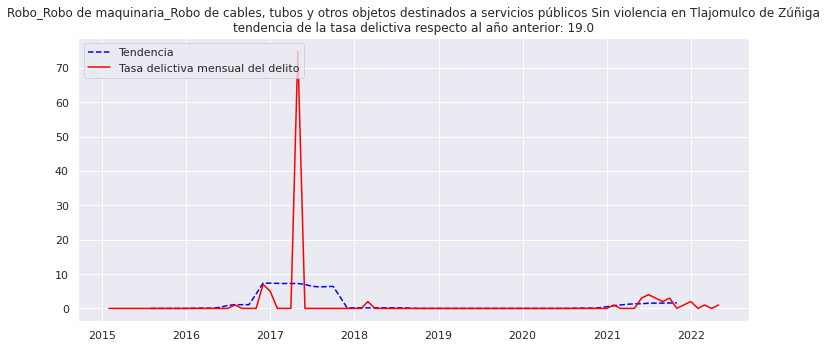

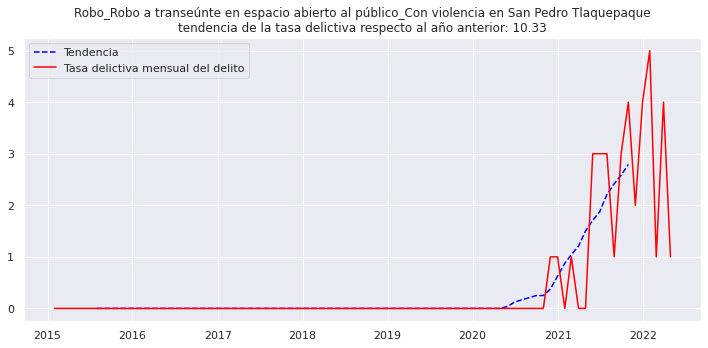

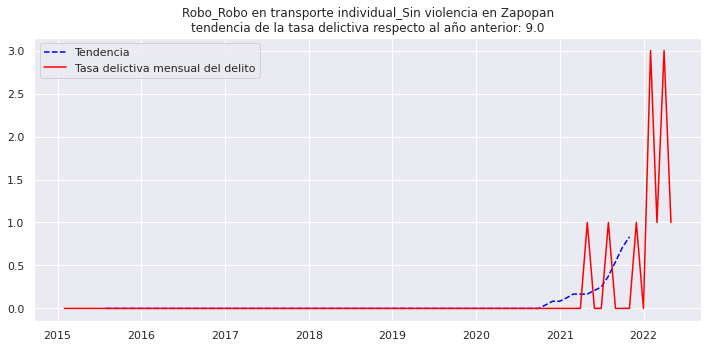

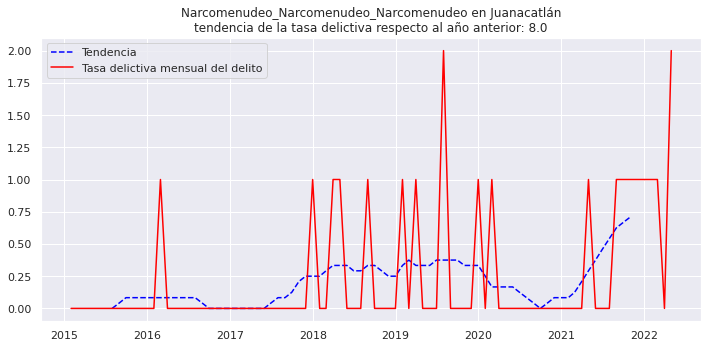

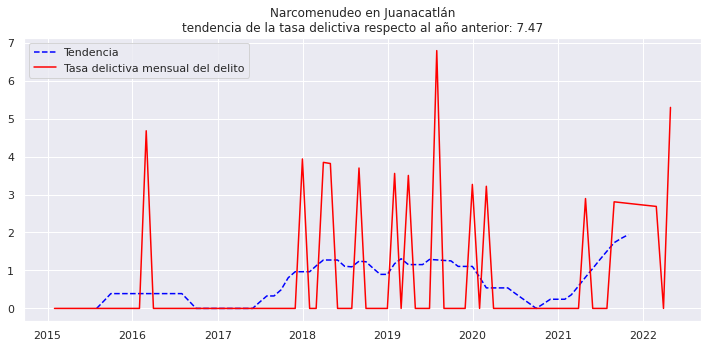

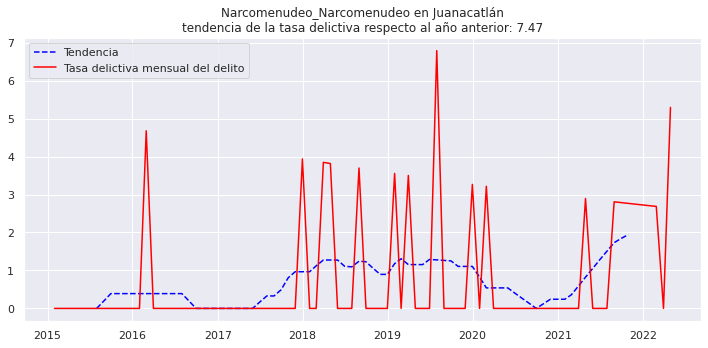

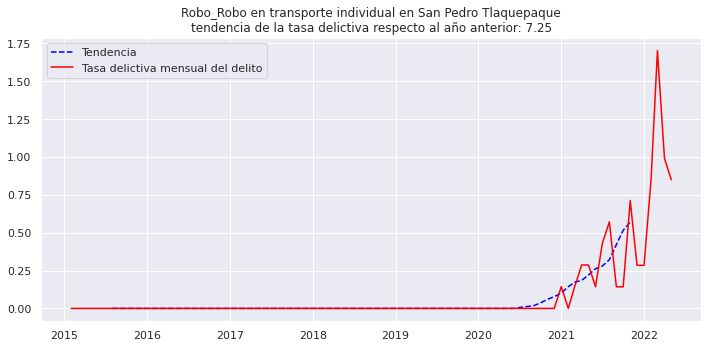

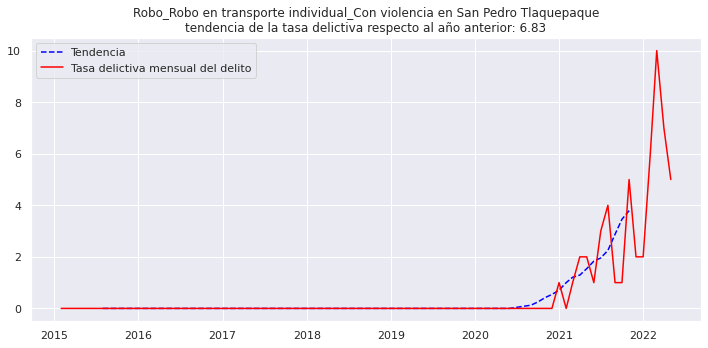

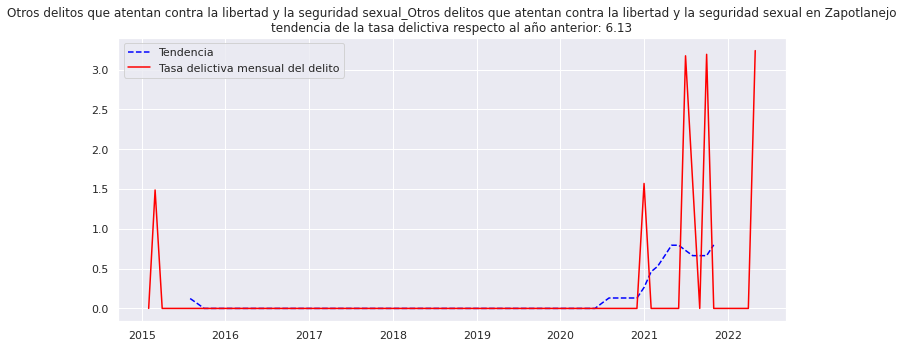

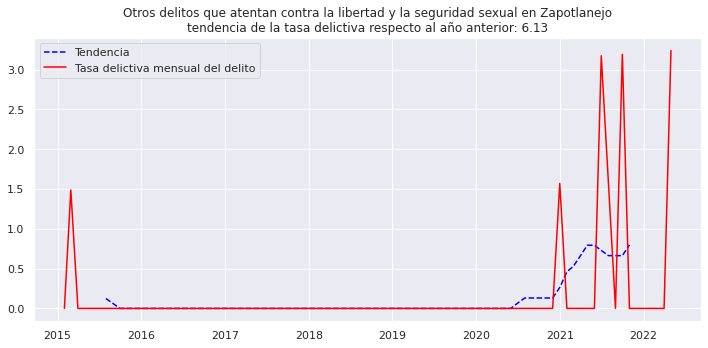

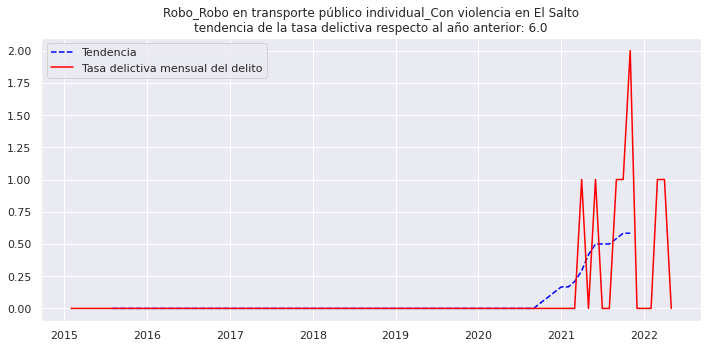

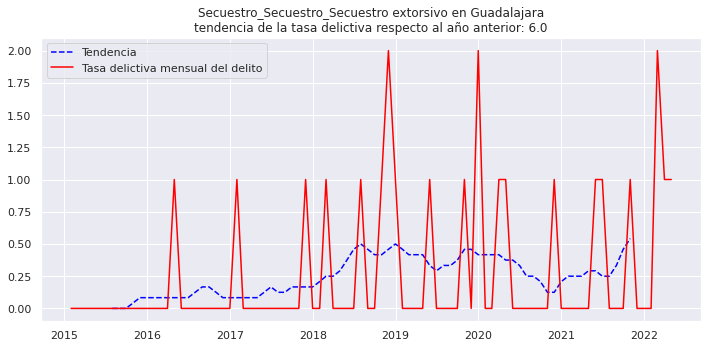

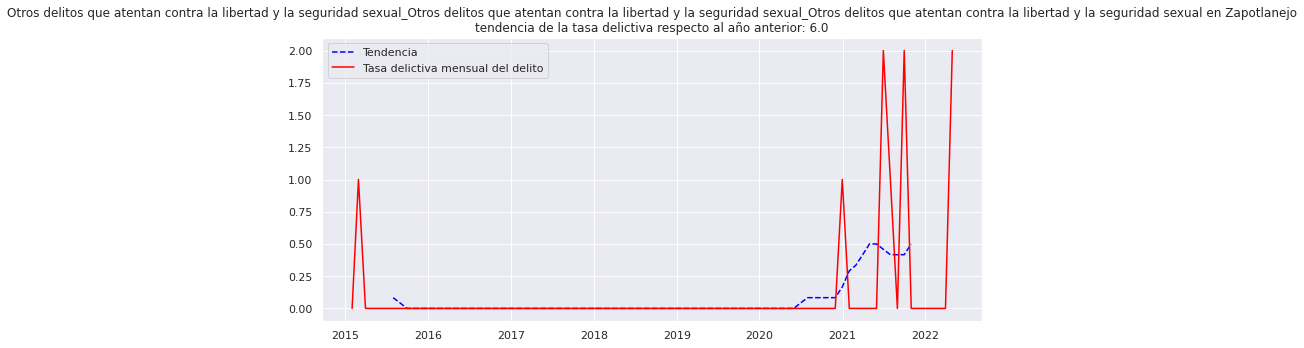

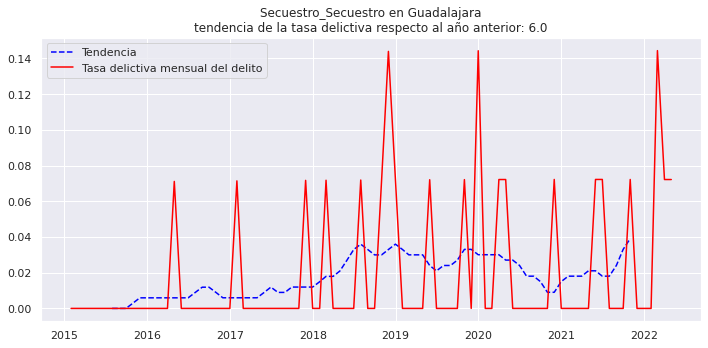

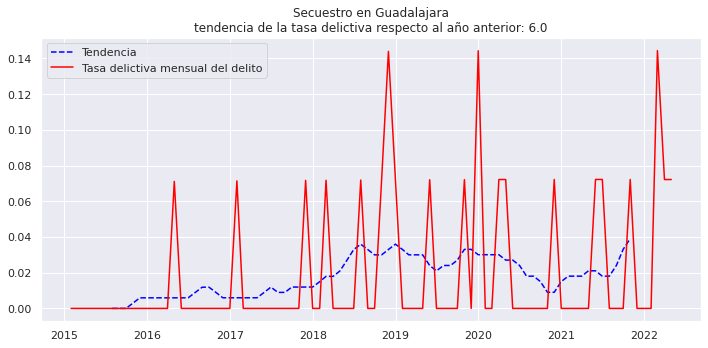

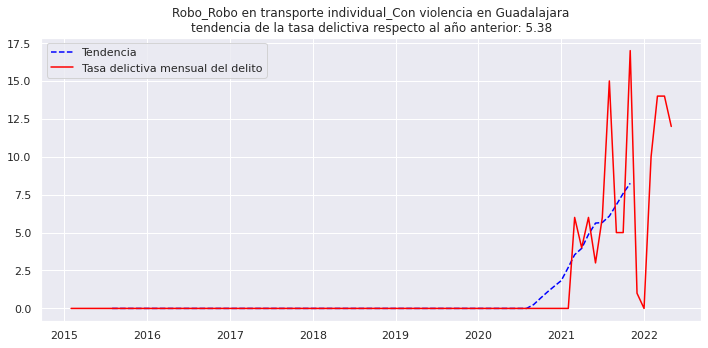

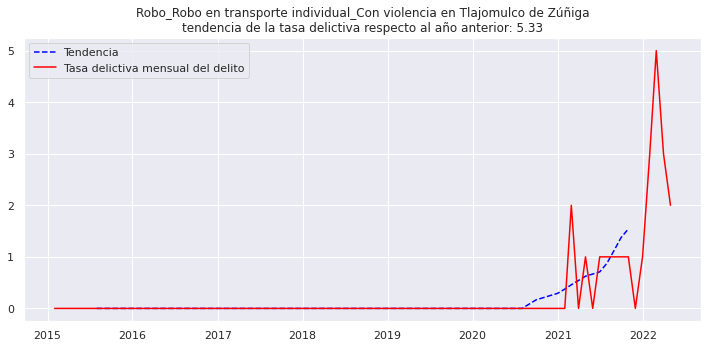

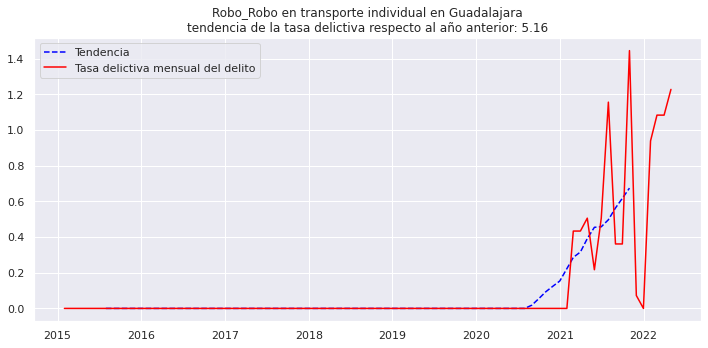

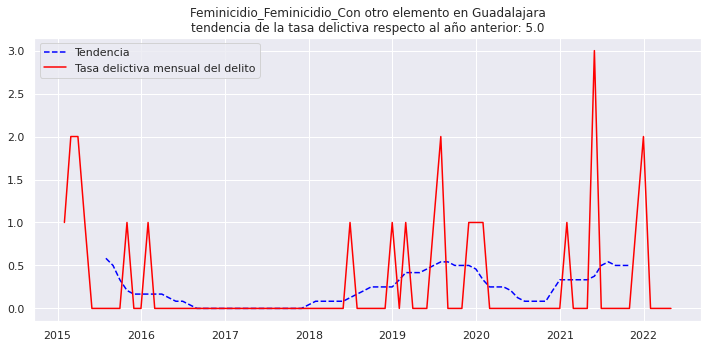

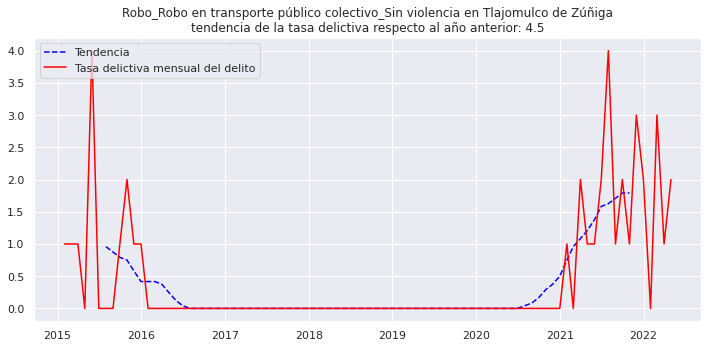

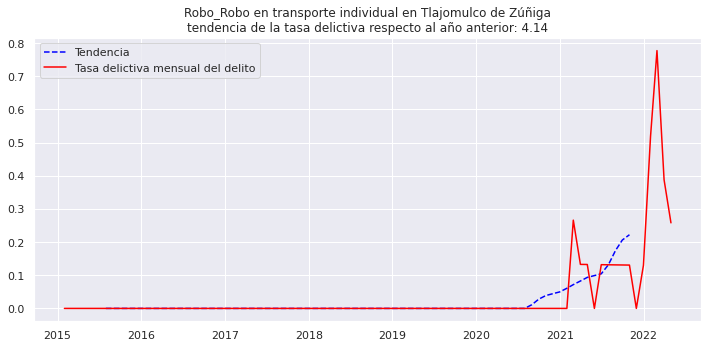

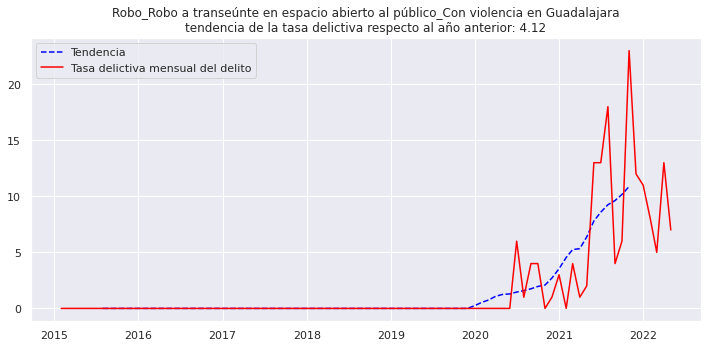

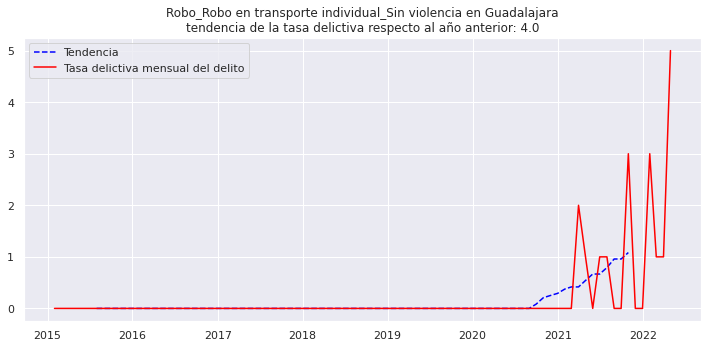

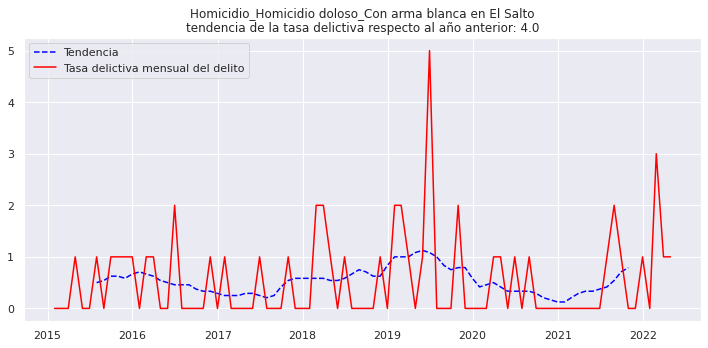

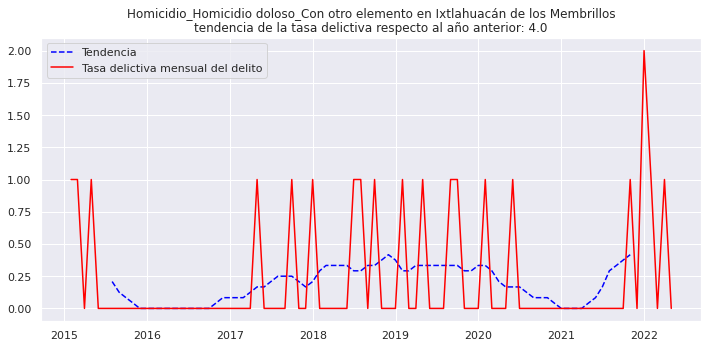

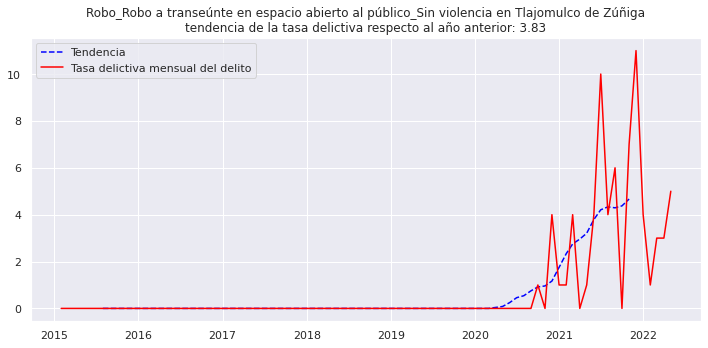

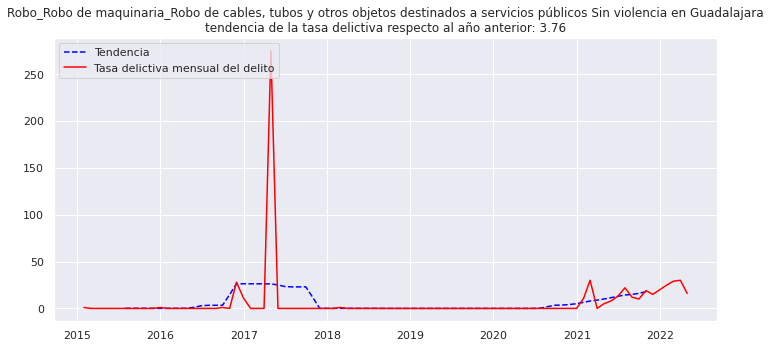

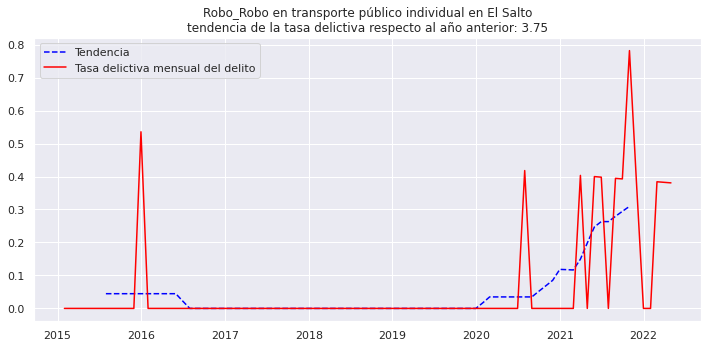

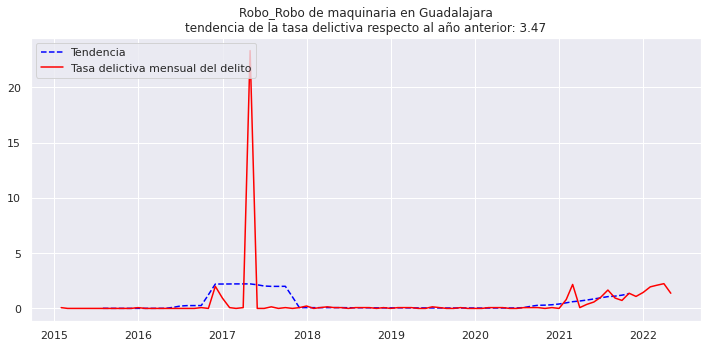

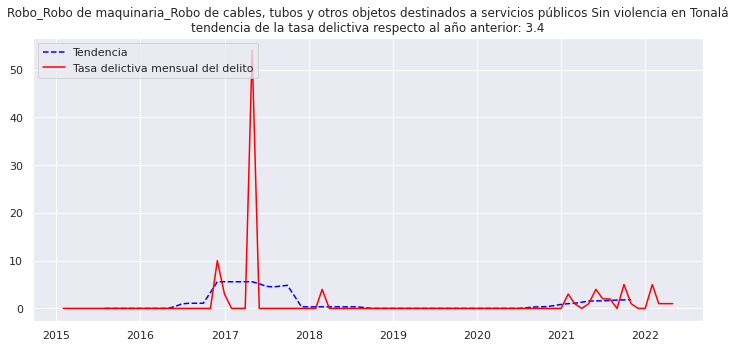

In [36]:
for index in range(0,30):    
    index_delito_municipio = df_dsct.iloc[index,:]
    municipio = index_delito_municipio.loc['municipio']
    delito = index_delito_municipio.loc['delito']
    df_delito_municipio = dict_delitos_tasa[municipio][delito]
    
    decom = sm.tsa.seasonal_decompose(df_delito_municipio, model = 'additive')

    fig, ax = plt.subplots() 
    ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='blue')
    ax.plot(decom.observed.index, decom.observed.values, label = 'Tasa delictiva mensual del delito', color='red')
    ax.set_title(delito+' en '+municipio+'\n'+'tendencia de la tasa delictiva respecto al año anterior: '+str(round(df_dsct.iloc[index,:]['trend'], 2)))
    
    ax.legend(loc='upper left')
    fig.tight_layout()
    #plt.savefig('Plots/corr/'+str(delito)+'_'+str(municipio)+'.png', format='png', dpi=800)
    plt.plot()